# Daily Dose of Data Science

This notebook accompanies the code for Bagging article.

Read the full blog here: [Why Bagging is So Ridiculously Effective At Variance Reduction?](https://www.dailydoseofds.com/why-bagging-is-so-ridiculously-effective-at-variance-reduction)

Author: Avi Chawla

## Imports

In [1]:
import seaborn as sns

sns.set()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['font.family'] = ['Comic Sans MS', 'sans-serif']

colors = ['#fe7c73', '#2471A3']

## Linear Regression vs. Decision Tree

### Generate the dataset

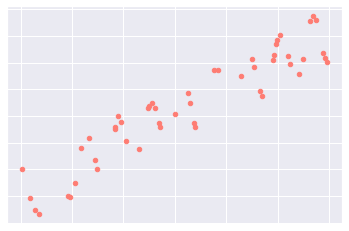

In [4]:
X = np.linspace(-3, 3, 500).reshape(-1, 1)
y = 2*X + 2*np.sin(X*10) + np.random.normal(0, 0.1, X.shape[0]).reshape(-1, 1)

num_samples = 50  # You can change this value to the desired number of samples
random_indices = np.random.choice(len(X), num_samples, replace=False)

# Sample corresponding points from both arrays using the random indices
sampled_array1 = X[random_indices]
sampled_array2 = y[random_indices]

sampled_array2 = sampled_array2[sampled_array1.argsort(0)].squeeze().reshape(-1, 1)
sampled_array1 = sampled_array1[sampled_array1.argsort(0)].squeeze().reshape(-1, 1)

fig, ax = plt.subplots()

ax.scatter(sampled_array1, sampled_array2, label='Data', color=colors[0], s=20)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

### Overfitting with Decision Tree

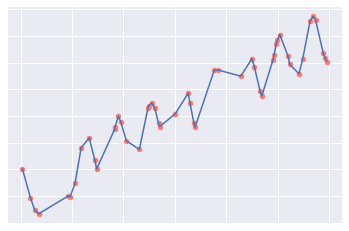

In [5]:
tree_model = DecisionTreeRegressor().fit(sampled_array1, sampled_array2)

fig, ax = plt.subplots()

ax.scatter(sampled_array1, sampled_array2, label='Data', color=colors[0], s=20)
ax.plot(sampled_array1, tree_model.predict(sampled_array1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

### Overfitting with Linear Regression

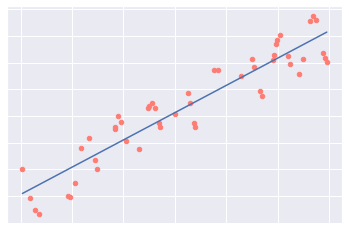

In [6]:
lr_model = LinearRegression().fit(sampled_array1, sampled_array2)

fig, ax = plt.subplots()

ax.scatter(sampled_array1, sampled_array2, label='Data', color=colors[0], s=20)
ax.plot(sampled_array1, lr_model.predict(sampled_array1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

### Overfitting with Polynomial Regression

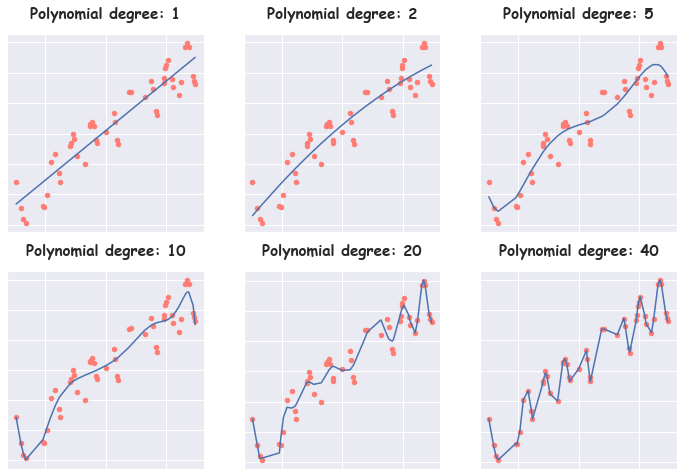

In [7]:
fig, ax = plt.subplot_mosaic("ABC;DEF", figsize=(12, 8))
degrees = [1, 2, 5, 10, 20, 40]

for degree, key in zip(degrees, ax.keys()):
    
    # Create polynomial regression model
    coeff = np.polyfit(sampled_array1.reshape(-1), sampled_array2, deg=degree).reshape(-1)
    lr_model2 = np.poly1d(coeff)

    ax[key].scatter(sampled_array1, sampled_array2, label='Data', color=colors[0], s=20)
    ax[key].plot(sampled_array1, lr_model2(sampled_array1))
    ax[key].set_xticklabels([])
    ax[key].set_yticklabels([])
    ax[key].set_title(f"Polynomial degree: {degree}", fontsize=15, weight="bold", pad=15)

plt.show()

## Towards Random Forest

### Dummy classification dataset

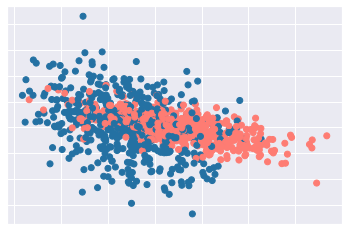

In [9]:
X, y = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_clusters_per_class=1,
    n_informative=2, class_sep=0.5,
    n_redundant=0,
    n_repeated=0
)

fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=[colors[i] for i in y])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

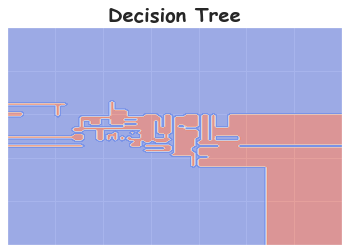

In [10]:
# train
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X, y)

# Decision region plot
xx, yy = np.meshgrid(np.linspace(np.floor(X[:, 0].min()), np.ceil(X[:, 0].max()), 100), np.linspace(np.floor(X[:, 1].min()), np.ceil(X[:, 1].max()), 100))
Z = dtree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
plt.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm_r')
ax.set_title("Decision Tree", fontsize = 20, fontweight = "bold")
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

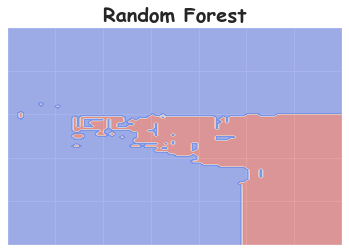

In [11]:
# train rf model
rfmodel = RandomForestClassifier(random_state=0)
rfmodel.fit(X, y)

# Decision region plot
xx, yy = np.meshgrid(np.linspace(np.floor(X[:, 0].min()), np.ceil(X[:, 0].max()), 100), np.linspace(np.floor(X[:, 1].min()), np.ceil(X[:, 1].max()), 100))
Z = rfmodel.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
plt.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm_r')
ax.set_title("Random Forest", fontsize = 20, fontweight = "bold")
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

### Proof that correlation is scale invariant

In [12]:
size = 100

X = 10*np.random.rand(size)  # Original variable X
Y = 2 * X + 5*np.random.random(size)  # Original variable Y (with a linear relationship)

# Calculate the correlation before scaling
correlation_before_scaling = np.corrcoef(X, Y)[0, 1]

# Scale both variables equally
scaling_factor = 1/5
X_scaled = X * scaling_factor
Y_scaled = Y * scaling_factor

# Calculate the correlation after scaling
correlation_after_scaling = np.corrcoef(X_scaled, Y_scaled)[0, 1]

print(f"Correlation before scaling: {correlation_before_scaling:.2f}")
print(f"Correlation after scaling: {correlation_after_scaling:.2f}")

Correlation before scaling: 0.98
Correlation after scaling: 0.98


## Custom Random Forest Experiment

### Define bootstrapping function

In [13]:
def sampling_function(df, final_size, initial_sample_ratio):
    
    total_samples = df.shape[0]
    initial_sample_size = int(initial_sample_ratio*total_samples)
    
    initial_sample_df = df.sample(initial_sample_size)
    
    sampled_rows = pd.DataFrame()
    
    remaining_rows = final_size - initial_sample_size
    for i in range(remaining_rows):
        sampled_row = initial_sample_df.sample(1)
        
        sampled_rows = pd.concat((sampled_rows, sampled_row))
        
    bootstrapped_dataset = pd.concat((initial_sample_df, sampled_rows))
    return bootstrapped_dataset

### Define prediction function

In [14]:
from collections import Counter

def predict(models, test_data):
    # Assuming you have test data 'X_test' as a DataFrame
    predictions = []

    # Make predictions using each tree in 'all_trees'
    for model in models:
        model_predictions = model.predict(test_data)
        predictions.append(model_predictions)

    # Perform majority vote to aggregate predictions
    ensemble_predictions = []
    for i in range(len(test_data)):
        ensemble_prediction = Counter([prediction[i] for prediction in predictions]).most_common(1)[0][0]
        ensemble_predictions.append(ensemble_prediction)

    ensemble_predictions = np.array(ensemble_predictions)
    
    return ensemble_predictions

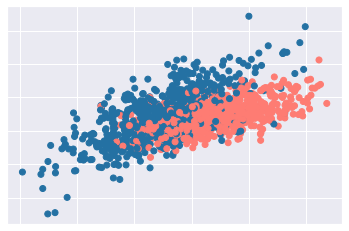

In [30]:
# Generate some synthetic data to train the decision tree on
X, y = make_classification(
    n_samples=1200, 
    n_features=2, 
    n_clusters_per_class=1,
    n_informative=2, class_sep=0.5,
    n_redundant=0,
    n_repeated=0
)

fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=[colors[i] for i in y])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

X_train, y_train = X[:1000], y[:1000]
X_test, y_test = X[1000:], y[1000:]

### Decision Tree model

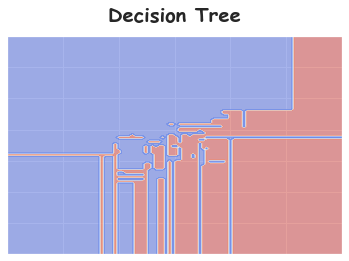

0.75

In [31]:

dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train, y_train)

xx, yy = np.meshgrid(np.linspace(np.floor(X_train[:, 0].min()), np.ceil(X_train[:, 0].max()), 100), np.linspace(np.floor(X_train[:, 1].min()), np.ceil(X_train[:, 1].max()), 100))
Z = dtree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
plt.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm_r')
ax.set_title("Decision Tree", fontsize = 20, fontweight = "bold", pad=15)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

dtree.score(X_test, y_test)

### Random Forest Model

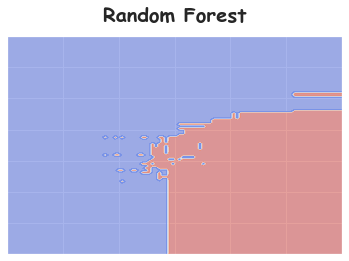

0.815

In [32]:
rfmodel = RandomForestClassifier(max_features="sqrt", max_samples=0.5, n_estimators=21)
rfmodel.fit(X_train, y_train)

xx, yy = np.meshgrid(np.linspace(np.floor(X_train[:, 0].min()), np.ceil(X_train[:, 0].max()), 100), np.linspace(np.floor(X_train[:, 1].min()), np.ceil(X_train[:, 1].max()), 100))
Z = rfmodel.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
plt.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm_r')
ax.set_title("Random Forest", fontsize = 20, fontweight = "bold", pad=15)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

rfmodel.score(X_test, y_test)

### Custom Model

In [33]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train[["X1", "X2"]] = X_train
df_train["y"] = y_train

df_test[["X1", "X2"]] = X_test
df_test["y"] = y_test

#### Train Models

In [34]:
total_models = 21
final_size = 2*df_train.shape[0]
initial_sample_ratio = 0.5

all_trees = []

for i in range(total_models):
    model = DecisionTreeClassifier(max_features="sqrt")
    data = sampling_function(df_train, final_size, initial_sample_ratio)
    
    model.fit(data[["X1", "X2"]], data['y'])
    
    all_trees.append(model)

#### Aggregate predictions and create plot

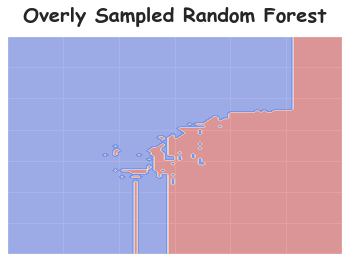

0.795

In [35]:
xx, yy = np.meshgrid(np.linspace(np.floor(X_train[:, 0].min()), np.ceil(X_train[:, 0].max()), 100), np.linspace(np.floor(X_train[:, 1].min()), np.ceil(X_train[:, 1].max()), 100))

Z = predict(all_trees, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
plt.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm_r')
ax.set_title("Overly Sampled Random Forest", fontsize = 20, fontweight = "bold", pad = 15)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

sum(predict(all_trees, df_test[["X1", "X2"]]) == df_test.y)/df_test.shape[0]

In [36]:
dtree_accuracy = dtree.score(X_test, y_test)
rf_accuracy = rfmodel.score(X_test, y_test)
custom_rf_accuracy = sum(predict(all_trees, df_test[["X1", "X2"]]) == df_test.y)/df_test.shape[0]

print(f"Decision Tree test accuracy: {dtree_accuracy}")
print(f"Random Forest test accuracy: {rf_accuracy}")
print(f"Custom Random Forest test accuracy: {custom_rf_accuracy}")

Decision Tree test accuracy: 0.75
Random Forest test accuracy: 0.815
Custom Random Forest test accuracy: 0.795
